## 1. Importing Libraries

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# ML Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Metrics
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                              f1_score, recall_score, precision_score, roc_curve, 
                              roc_auc_score, matthews_corrcoef)

# Imbalanced data handling
from imblearn.combine import SMOTEENN

# Explainability libraries - KEY FOR RO3
import shap
import lime
from lime import lime_tabular

# Visualization
from mlxtend.plotting import plot_confusion_matrix

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully!")
print(f"SHAP version: {shap.__version__}")
# LIME doesn't have __version__ attribute, but it's imported successfully

All libraries imported successfully!
SHAP version: 0.50.0


c:\Users\kingx\OneDrive\Documents\Masters\Part 3\CSP760\Dataset\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Loading the Preprocessed Data

In [2]:
# Load preprocessed data
data = pd.read_csv('BRFSS_preprocessed.csv')
print(f"Data shape: {data.shape}")

# Load selected features if available
try:
    with open('selected_features.txt', 'r') as f:
        selected_features = [line.strip() for line in f.readlines()]
    print(f"\nLoaded {len(selected_features)} selected features from file")
    use_selected_features = True
except FileNotFoundError:
    print("\nSelected features file not found. Using all features.")
    use_selected_features = False
    selected_features = None

display(data.head())

Data shape: (727123, 31)

Loaded 15 selected features from file


,YEAR,SEX,AGE,WGHT (lbs),HGHT (ft),BMI,EDUCATION_LEVEL,EMPLOYMENT_STATUS,INCOME_LEVEL,MARITAL_STATUS,...,HIGH_BP,BP_MEDS,HIGH_CHOL,CHOL_MEDS,HAD_STROKE,HAD_HEARTDISEASE,DIABETES_STATUS,BMI_CATEGORY,AGE_GROUP,DIABETES_BINARY
0,2023,0,5,172.0,5.25,30.47,4,7,7,1,...,3,1,0,0,0,0,3,3.0,2.0,1
1,2023,0,5,132.0,4.75,28.56,4,7,7,2,...,3,0,1,1,0,0,0,2.0,2.0,0
2,2023,0,5,130.0,5.33,22.34,3,7,2,3,...,3,1,1,1,0,0,0,1.0,2.0,0
3,2023,0,5,170.0,5.50,27.44,4,7,7,1,...,0,1,0,0,0,0,0,2.0,2.0,0
4,2023,0,5,170.0,5.67,25.82,4,0,7,3,...,3,1,0,0,0,0,3,2.0,2.0,1


## 3. Preparing Features and Target

In [3]:
# Define target variable
target = 'DIABETES_BINARY'

# Prepare features
if use_selected_features and selected_features:
    # Use selected features
    X = data[selected_features]
    print(f"Using {len(selected_features)} selected features")
else:
    # Use all features except target
    X = data.drop([target, 'DIABETES_STATUS'], axis=1, errors='ignore')
    print(f"Using all {X.shape[1]} features")

y = data[target]

# Check for and handle any remaining NaN values
print(f"\nNaN values in features: {X.isnull().sum().sum()}")
print(f"NaN values in target: {y.isnull().sum()}")

if X.isnull().sum().sum() > 0:
    print("Filling NaN values in features with 0...")
    X = X.fillna(0)

if y.isnull().sum() > 0:
    print("Dropping rows with NaN in target...")
    valid_indices = y.notna()
    X = X[valid_indices]
    y = y[valid_indices]

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:")
print(y.value_counts())
print(f"\nClass imbalance ratio: {y.value_counts()[0] / y.value_counts()[1]:.2f}:1")

Using 15 selected features

NaN values in features: 47114
NaN values in target: 0
Filling NaN values in features with 0...

Features shape: (727123, 15)
Target shape: (727123,)

Target distribution:
DIABETES_BINARY
0    621509
1    105614
Name: count, dtype: int64

Class imbalance ratio: 5.88:1


## 4. Feature Scaling

In [4]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("Features scaled successfully")
print(f"\nScaled features sample:")
display(X_scaled.head())

Features scaled successfully

Scaled features sample:


,AGE_GROUP,AGE,GEN_HLTH,WGHT (lbs),EXER_STATUS,BMI,BMI_CATEGORY,CHKP_STATUS,EMPLOYMENT_STATUS,BP_MEDS,DCTR_STATUS,SEX,CHOL_MEDS,EDUCATION_LEVEL,ALHL_STATUS
0,1.120483,0.981645,0.513901,-0.208212,-1.998811,0.359994,1.229243,0.973025,1.299465,0.153907,-0.330309,-0.969423,-0.360786,-0.112966,-0.044949
1,1.120483,0.981645,0.513901,-1.098240,0.500297,0.052744,0.022183,0.973025,1.299465,-6.497447,-0.330309,-0.969423,2.771729,-0.112966,-0.044949
2,1.120483,0.981645,-1.569523,-1.142742,0.500297,-0.947827,-1.184876,-0.395599,1.299465,0.153907,-0.330309,-0.969423,2.771729,-1.153244,-0.044949
3,1.120483,0.981645,0.513901,-0.252713,0.500297,-0.127423,0.022183,2.341650,1.299465,0.153907,-0.330309,-0.969423,-0.360786,-0.112966,-0.044949
4,1.120483,0.981645,-1.569523,-0.252713,0.500297,-0.388022,0.022183,-0.395599,-1.229929,0.153907,-0.330309,-0.969423,-0.360786,-0.112966,-0.757918


## 5. Train-Test Split (Before SMOTEENN)

In [5]:
# Split data before applying SMOTEENN (to avoid data leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

Training set size: (508986, 15)
Test set size: (218137, 15)

Training set class distribution:
DIABETES_BINARY
0    435056
1     73930
Name: count, dtype: int64

Test set class distribution:
DIABETES_BINARY
0    186453
1     31684
Name: count, dtype: int64


## 6. Handling Imbalanced Data with SMOTEENN

**SMOTEENN** combines:
- **SMOTE**: Generates synthetic samples for minority class
- **ENN**: Removes noisy samples from both classes

This addresses class imbalance and improves model performance.

Applying SMOTEENN to balance training data...

Original training set: (508986, 15)
Resampled training set: (566352, 15)

Original class distribution:
DIABETES_BINARY
0    435056
1     73930
Name: count, dtype: int64

Resampled class distribution:
DIABETES_BINARY
1    290082
0    276270
Name: count, dtype: int64


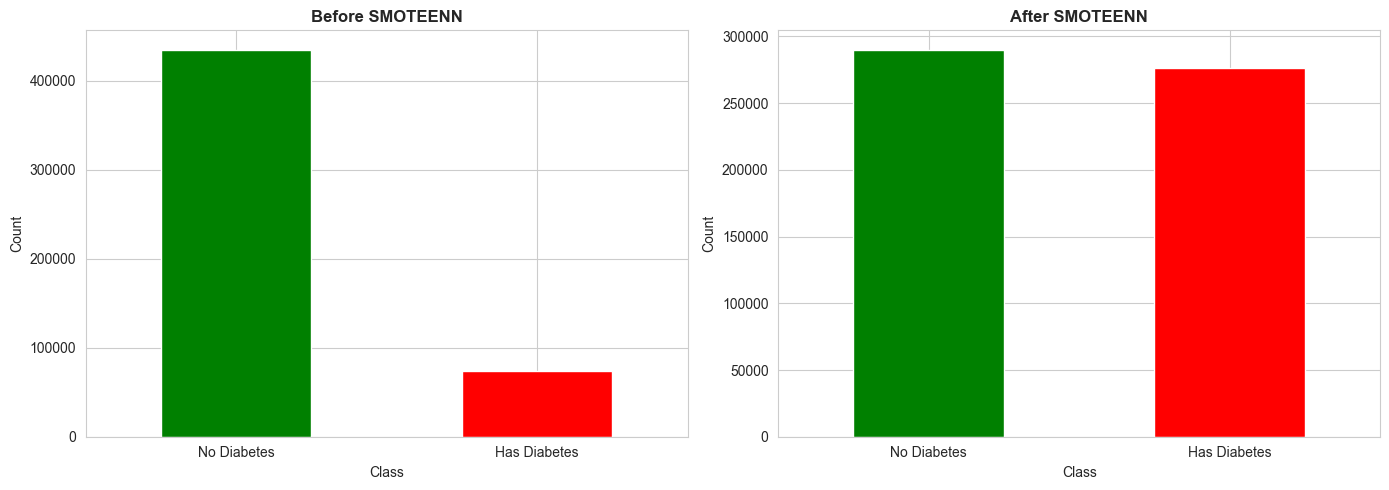

In [6]:
# Apply SMOTEENN to training data only
print("Applying SMOTEENN to balance training data...")
smoteenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)

print(f"\nOriginal training set: {X_train.shape}")
print(f"Resampled training set: {X_train_resampled.shape}")
print(f"\nOriginal class distribution:")
print(y_train.value_counts())
print(f"\nResampled class distribution:")
print(pd.Series(y_train_resampled).value_counts())

# Visualize the effect
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

y_train.value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Before SMOTEENN', fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['No Diabetes', 'Has Diabetes'], rotation=0)

pd.Series(y_train_resampled).value_counts().plot(kind='bar', ax=axes[1], color=['green', 'red'])
axes[1].set_title('After SMOTEENN', fontweight='bold')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['No Diabetes', 'Has Diabetes'], rotation=0)

plt.tight_layout()
plt.show()

## 7. Model Training & Evaluation
### 7.1 Random Forest (RF)

In [7]:
print("="*80)
print("TRAINING RANDOM FOREST MODEL")
print("="*80)

# Train Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=16,
    max_features=16,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_resampled, y_train_resampled)
print("Random Forest model trained successfully!")

# Training accuracy
y_pred_train_rf = rf.predict(X_train_resampled)
acc_train_rf = accuracy_score(y_train_resampled, y_pred_train_rf)
print(f"\nTraining Accuracy: {acc_train_rf:.4f}")

# Test predictions
y_pred_test_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]

# Test accuracy
acc_test_rf = accuracy_score(y_test, y_pred_test_rf)
print(f"Test Accuracy: {acc_test_rf:.4f}")

TRAINING RANDOM FOREST MODEL
Random Forest model trained successfully!

Training Accuracy: 0.9075
Test Accuracy: 0.7144


In [8]:
# Detailed metrics for Random Forest
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_test_rf, target_names=['No Diabetes', 'Has Diabetes']))

print(f"\nPrecision: {precision_score(y_test, y_pred_test_rf):.4f}")
print(f"Recall (Sensitivity): {recall_score(y_test, y_pred_test_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_test_rf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print(f"Matthews Correlation Coefficient: {matthews_corrcoef(y_test, y_pred_test_rf):.4f}")


Classification Report (Random Forest):
              precision    recall  f1-score   support

 No Diabetes       0.93      0.72      0.81    186453
Has Diabetes       0.29      0.68      0.41     31684

    accuracy                           0.71    218137
   macro avg       0.61      0.70      0.61    218137
weighted avg       0.84      0.71      0.75    218137


Precision: 0.2914
Recall (Sensitivity): 0.6752
F1-Score: 0.4071
ROC-AUC: 0.7693
Matthews Correlation Coefficient: 0.2955


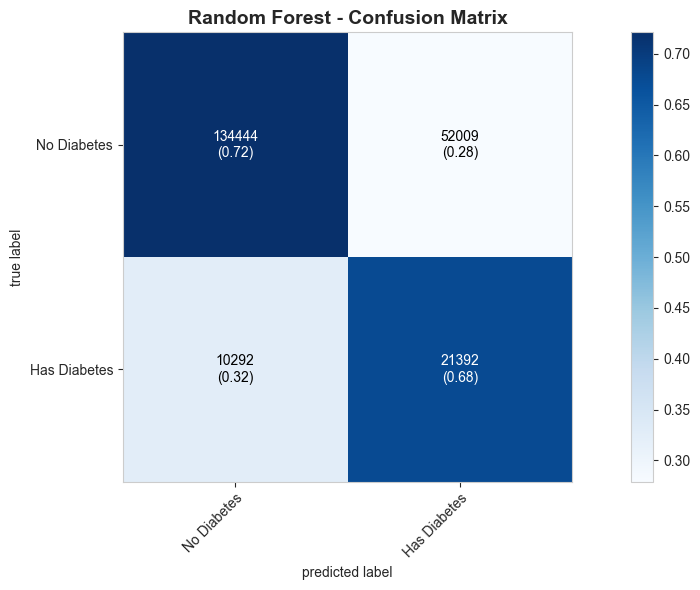

In [9]:
# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_test_rf)
fig, ax = plot_confusion_matrix(conf_mat=cm_rf, show_absolute=True,
                                 show_normed=True, colorbar=True,
                                 class_names=['No Diabetes', 'Has Diabetes'])
plt.title('Random Forest - Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 7.2 Logistic Regression (LR)

In [10]:
print("="*80)
print("TRAINING LOGISTIC REGRESSION MODEL")
print("="*80)

# Train Logistic Regression
lr = LogisticRegression(
    max_iter=1000,
    C=1.0,
    solver='lbfgs',
    random_state=42,
    n_jobs=-1
)

lr.fit(X_train_resampled, y_train_resampled)
print("Logistic Regression model trained successfully!")

# Training accuracy
y_pred_train_lr = lr.predict(X_train_resampled)
acc_train_lr = accuracy_score(y_train_resampled, y_pred_train_lr)
print(f"\nTraining Accuracy: {acc_train_lr:.4f}")

# Test predictions
y_pred_test_lr = lr.predict(X_test)
y_pred_proba_lr = lr.predict_proba(X_test)[:, 1]

# Test accuracy
acc_test_lr = accuracy_score(y_test, y_pred_test_lr)
print(f"Test Accuracy: {acc_test_lr:.4f}")

TRAINING LOGISTIC REGRESSION MODEL
Logistic Regression model trained successfully!

Training Accuracy: 0.8131
Test Accuracy: 0.6520


In [11]:
# Detailed metrics for Logistic Regression
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_test_lr, target_names=['No Diabetes', 'Has Diabetes']))

print(f"\nPrecision: {precision_score(y_test, y_pred_test_lr):.4f}")
print(f"Recall (Sensitivity): {recall_score(y_test, y_pred_test_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_test_lr):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")
print(f"Matthews Correlation Coefficient: {matthews_corrcoef(y_test, y_pred_test_lr):.4f}")


Classification Report (Logistic Regression):
              precision    recall  f1-score   support

 No Diabetes       0.94      0.63      0.76    186453
Has Diabetes       0.26      0.78      0.39     31684

    accuracy                           0.65    218137
   macro avg       0.60      0.70      0.57    218137
weighted avg       0.84      0.65      0.70    218137


Precision: 0.2637
Recall (Sensitivity): 0.7787
F1-Score: 0.3940
ROC-AUC: 0.7707
Matthews Correlation Coefficient: 0.2913


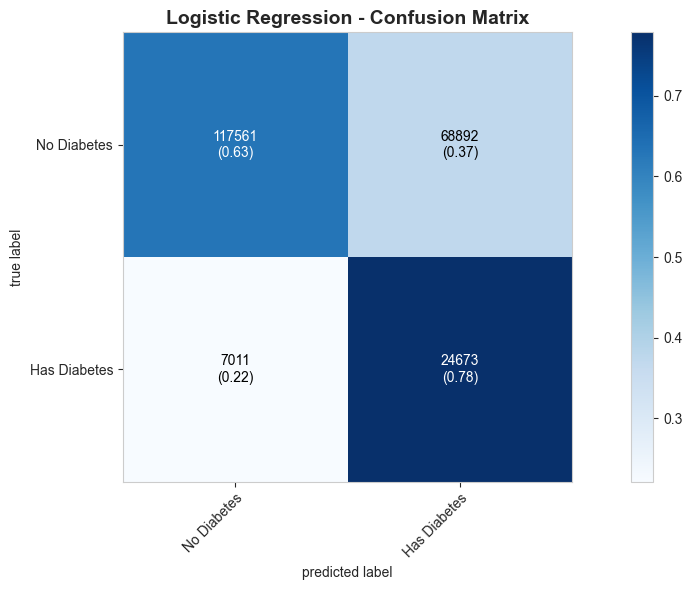

In [12]:
# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_test_lr)
fig, ax = plot_confusion_matrix(conf_mat=cm_lr, show_absolute=True,
                                 show_normed=True, colorbar=True,
                                 class_names=['No Diabetes', 'Has Diabetes'])
plt.title('Logistic Regression - Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 7.3 Extreme Gradient Boosting (XGBoost)

In [13]:
print("="*80)
print("TRAINING XGBOOST MODEL")
print("="*80)

# Train XGBoost
xgb = XGBClassifier(
    max_depth=20,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb.fit(X_train_resampled, y_train_resampled)
print("XGBoost model trained successfully!")

# Training accuracy
y_pred_train_xgb = xgb.predict(X_train_resampled)
acc_train_xgb = accuracy_score(y_train_resampled, y_pred_train_xgb)
print(f"\nTraining Accuracy: {acc_train_xgb:.4f}")

# Test predictions
y_pred_test_xgb = xgb.predict(X_test)
y_pred_proba_xgb = xgb.predict_proba(X_test)[:, 1]

# Test accuracy
acc_test_xgb = accuracy_score(y_test, y_pred_test_xgb)
print(f"Test Accuracy: {acc_test_xgb:.4f}")

TRAINING XGBOOST MODEL
XGBoost model trained successfully!

Training Accuracy: 0.9789
Test Accuracy: 0.7573


In [14]:
# Detailed metrics for XGBoost
print("\nClassification Report (XGBoost):")
print(classification_report(y_test, y_pred_test_xgb, target_names=['No Diabetes', 'Has Diabetes']))

print(f"\nPrecision: {precision_score(y_test, y_pred_test_xgb):.4f}")
print(f"Recall (Sensitivity): {recall_score(y_test, y_pred_test_xgb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_test_xgb):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")
print(f"Matthews Correlation Coefficient: {matthews_corrcoef(y_test, y_pred_test_xgb):.4f}")


Classification Report (XGBoost):
              precision    recall  f1-score   support

 No Diabetes       0.91      0.79      0.85    186453
Has Diabetes       0.31      0.56      0.40     31684

    accuracy                           0.76    218137
   macro avg       0.61      0.67      0.62    218137
weighted avg       0.83      0.76      0.78    218137


Precision: 0.3116
Recall (Sensitivity): 0.5552
F1-Score: 0.3992
ROC-AUC: 0.7638
Matthews Correlation Coefficient: 0.2790


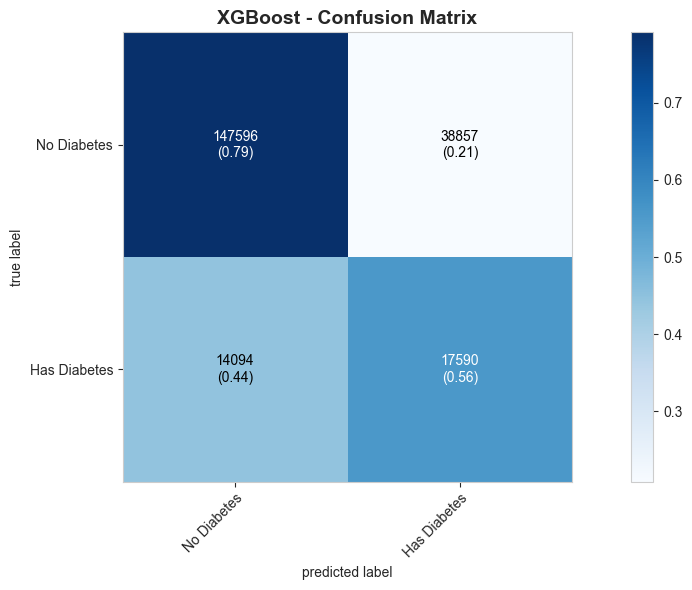

In [15]:
# Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_test_xgb)
fig, ax = plot_confusion_matrix(conf_mat=cm_xgb, show_absolute=True,
                                 show_normed=True, colorbar=True,
                                 class_names=['No Diabetes', 'Has Diabetes'])
plt.title('XGBoost - Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 7.4 LightGBM (Fast Gradient Boosting)

In [16]:
print("="*80)
print("TRAINING LIGHTGBM MODEL")
print("="*80)

# Train LightGBM
lgbm = LGBMClassifier(
    max_depth=20,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    verbose=-1  # Suppress warnings
)

lgbm.fit(X_train_resampled, y_train_resampled)
print("LightGBM model trained successfully!")

# Training accuracy
y_pred_train_lgbm = lgbm.predict(X_train_resampled)
acc_train_lgbm = accuracy_score(y_train_resampled, y_pred_train_lgbm)
print(f"\nTraining Accuracy: {acc_train_lgbm:.4f}")

# Test predictions
y_pred_test_lgbm = lgbm.predict(X_test)
y_pred_proba_lgbm = lgbm.predict_proba(X_test)[:, 1]

# Test accuracy
acc_test_lgbm = accuracy_score(y_test, y_pred_test_lgbm)
print(f"Test Accuracy: {acc_test_lgbm:.4f}")

TRAINING LIGHTGBM MODEL
LightGBM model trained successfully!

Training Accuracy: 0.9053
Test Accuracy: 0.7444


In [17]:
# Detailed metrics for LightGBM
print("\nClassification Report (LightGBM):")
print(classification_report(y_test, y_pred_test_lgbm, target_names=['No Diabetes', 'Has Diabetes']))

print(f"\nPrecision: {precision_score(y_test, y_pred_test_lgbm):.4f}")
print(f"Recall (Sensitivity): {recall_score(y_test, y_pred_test_lgbm):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_test_lgbm):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lgbm):.4f}")
print(f"Matthews Correlation Coefficient: {matthews_corrcoef(y_test, y_pred_test_lgbm):.4f}")


Classification Report (LightGBM):
              precision    recall  f1-score   support

 No Diabetes       0.92      0.76      0.84    186453
Has Diabetes       0.31      0.63      0.42     31684

    accuracy                           0.74    218137
   macro avg       0.62      0.70      0.63    218137
weighted avg       0.84      0.74      0.78    218137


Precision: 0.3123
Recall (Sensitivity): 0.6322
F1-Score: 0.4181
ROC-AUC: 0.7775
Matthews Correlation Coefficient: 0.3060


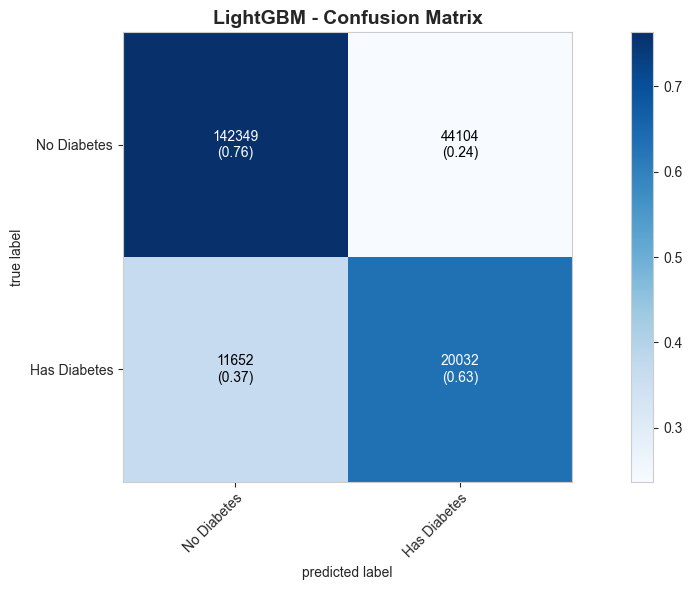

In [18]:
# Confusion Matrix for LightGBM
cm_lgbm = confusion_matrix(y_test, y_pred_test_lgbm)
fig, ax = plot_confusion_matrix(conf_mat=cm_lgbm, show_absolute=True,
                                 show_normed=True, colorbar=True,
                                 class_names=['No Diabetes', 'Has Diabetes'])
plt.title('LightGBM - Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Model Comparison


MODEL PERFORMANCE COMPARISON


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.6520,0.2637,0.7787,0.3940,0.7707
1,Random Forest,0.7144,0.2914,0.6752,0.4071,0.7693
2,XGBoost,0.7573,0.3116,0.5552,0.3992,0.7638
3,LightGBM,0.7444,0.3123,0.6322,0.4181,0.7775


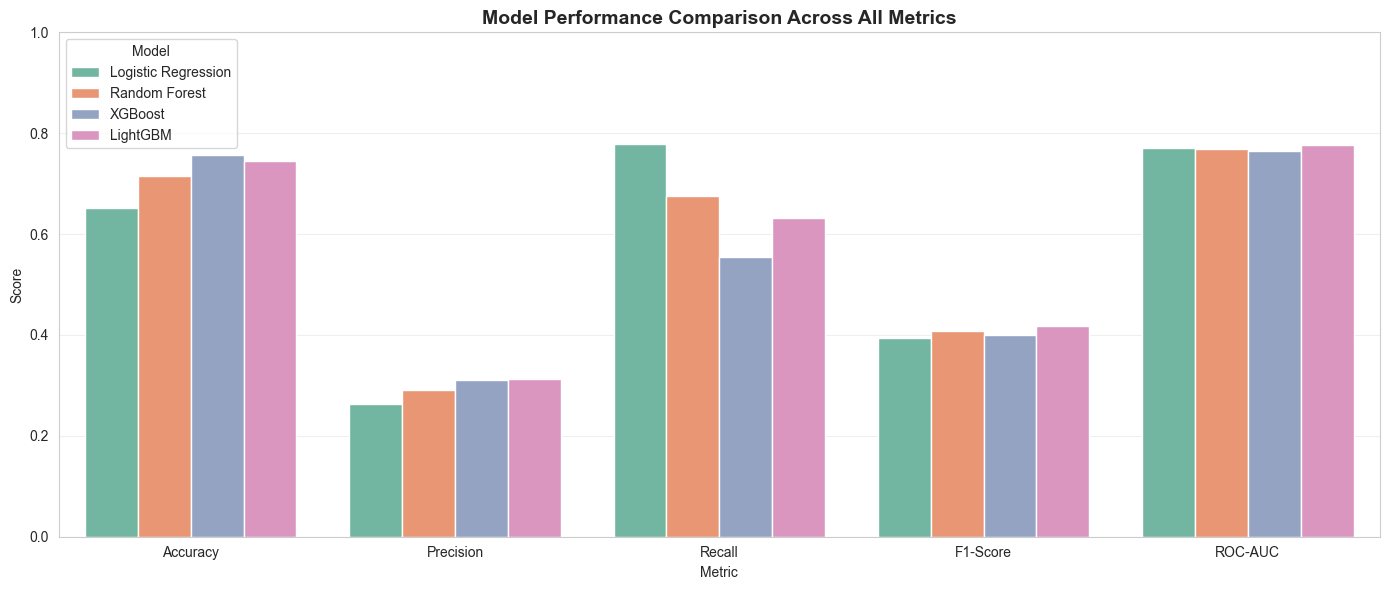

In [19]:
# Compare all models
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_test_lr),
        accuracy_score(y_test, y_pred_test_rf),
        accuracy_score(y_test, y_pred_test_xgb),
        accuracy_score(y_test, y_pred_test_lgbm)
    ],
    'Precision': [
        precision_score(y_test, y_pred_test_lr),
        precision_score(y_test, y_pred_test_rf),
        precision_score(y_test, y_pred_test_xgb),
        precision_score(y_test, y_pred_test_lgbm)
    ],
    'Recall': [
        recall_score(y_test, y_pred_test_lr),
        recall_score(y_test, y_pred_test_rf),
        recall_score(y_test, y_pred_test_xgb),
        recall_score(y_test, y_pred_test_lgbm)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_test_lr),
        f1_score(y_test, y_pred_test_rf),
        f1_score(y_test, y_pred_test_xgb),
        f1_score(y_test, y_pred_test_lgbm)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_pred_proba_lr),
        roc_auc_score(y_test, y_pred_proba_rf),
        roc_auc_score(y_test, y_pred_proba_xgb),
        roc_auc_score(y_test, y_pred_proba_lgbm)
    ]
})

print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
display(results.round(4))

# Visualize comparison
results_melted = results.melt(id_vars=['Model'], var_name='Metric', value_name='Score')

plt.figure(figsize=(14, 6))
sns.barplot(data=results_melted, x='Metric', y='Score', hue='Model', palette='Set2')
plt.title('Model Performance Comparison Across All Metrics', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 9. ROC Curves Comparison

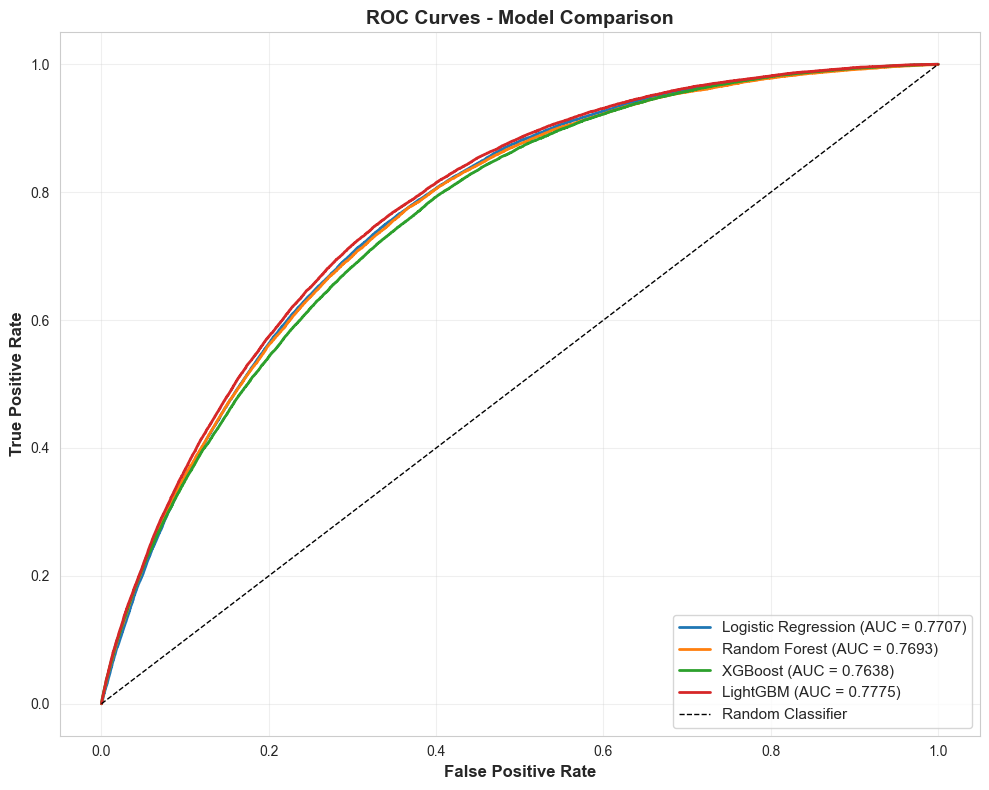

In [20]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.4f})', linewidth=2)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})', linewidth=2)

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.4f})', linewidth=2)

# LightGBM
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_pred_proba_lgbm)
auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (AUC = {auc_lgbm:.4f})', linewidth=2)

# Random baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Model Explainability with SHAP (RO3 Requirement)

**SHAP (SHapley Additive exPlanations)** provides:
- Global feature importance across all predictions
- Individual prediction explanations
- Understanding of how each feature contributes to predictions

### 10.1 SHAP for Random Forest

In [21]:
print("="*80)
print("SHAP ANALYSIS FOR RANDOM FOREST")
print("="*80)

# Create SHAP explainer for Random Forest
# Use a sample of test data for faster computation
sample_size = min(1000, len(X_test))
X_test_sample = X_test.sample(n=sample_size, random_state=42)

explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_test_sample)

# If shap_values is a list (for multi-class), take the positive class
if isinstance(shap_values_rf, list):
    shap_values_rf = shap_values_rf[1]

print(f"SHAP values computed for {sample_size} test samples")

SHAP ANALYSIS FOR RANDOM FOREST
SHAP values computed for 1000 test samples


<Figure size 1200x800 with 0 Axes>

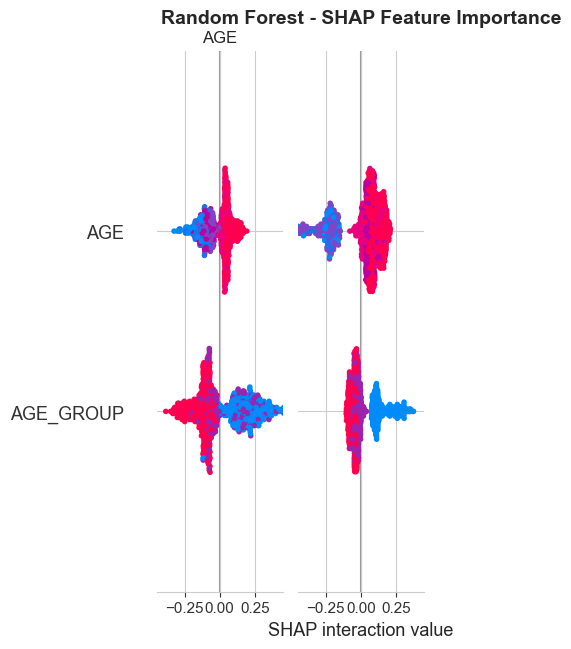

In [22]:
# SHAP Summary Plot (Global Feature Importance)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_rf, X_test_sample, plot_type="bar", show=False)
plt.title('Random Forest - SHAP Feature Importance', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

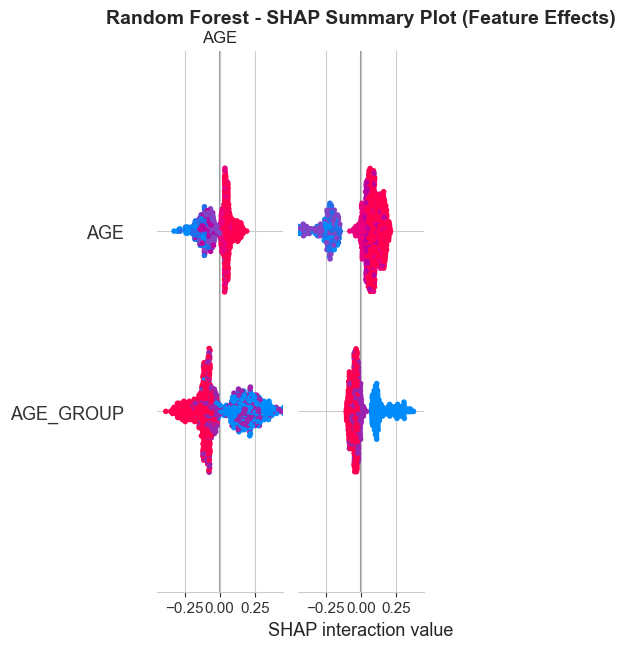

In [23]:
# SHAP Beeswarm Plot (shows feature effects)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_rf, X_test_sample, show=False)
plt.title('Random Forest - SHAP Summary Plot (Feature Effects)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


Explaining prediction for test instance 0:
Actual class: 0
Predicted class: 0
Predicted probability: 0.0004


<Figure size 1200x600 with 0 Axes>

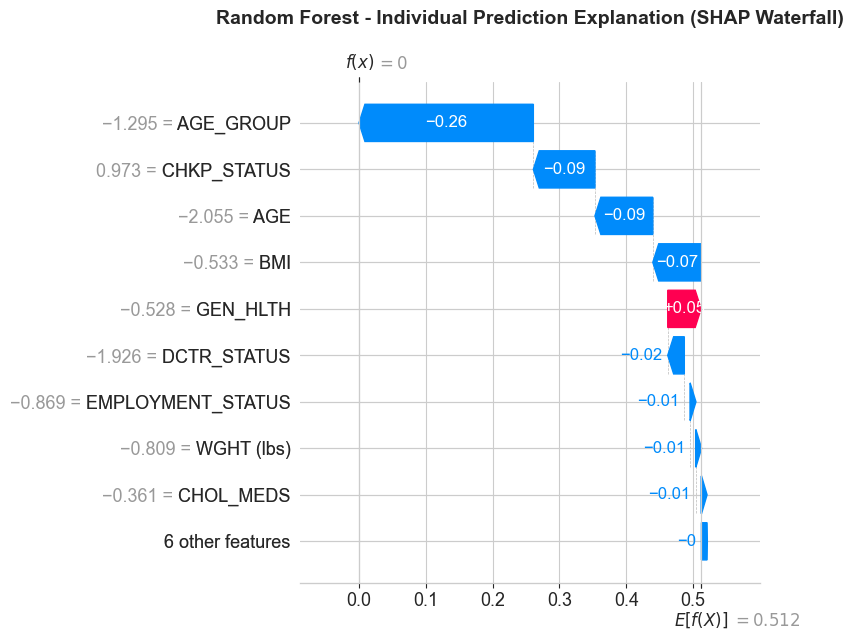

In [26]:
# SHAP Waterfall Plot for a single prediction (individual explanation)
# Select a random instance
instance_idx = 0
print(f"\nExplaining prediction for test instance {instance_idx}:")
print(f"Actual class: {y_test.iloc[X_test_sample.index[instance_idx]]}")
print(f"Predicted class: {rf.predict(X_test_sample.iloc[[instance_idx]])[0]}")
print(f"Predicted probability: {rf.predict_proba(X_test_sample.iloc[[instance_idx]])[0][1]:.4f}")

# Create explanation object
# Ensure we're using 1D array for waterfall plot (positive class only)
shap_values_instance = shap_values_rf[instance_idx]
if len(shap_values_instance.shape) > 1:
    shap_values_instance = shap_values_instance[:, 1]  # Select positive class

# Extract base value as scalar for positive class
if isinstance(explainer_rf.expected_value, (list, np.ndarray)):
    base_value = float(explainer_rf.expected_value[1]) if len(explainer_rf.expected_value) > 1 else float(explainer_rf.expected_value[0])
else:
    base_value = float(explainer_rf.expected_value)

shap_explanation = shap.Explanation(
    values=shap_values_instance,
    base_values=base_value,
    data=X_test_sample.iloc[instance_idx],
    feature_names=X_test_sample.columns.tolist()
)

plt.figure(figsize=(12, 6))
shap.waterfall_plot(shap_explanation, show=False)
plt.title('Random Forest - Individual Prediction Explanation (SHAP Waterfall)', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### 10.2 SHAP for XGBoost (Best Model)

In [27]:
print("="*80)
print("SHAP ANALYSIS FOR XGBOOST")
print("="*80)

# Create SHAP explainer for XGBoost
explainer_xgb = shap.TreeExplainer(xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test_sample)

print(f"SHAP values computed for {sample_size} test samples")

SHAP ANALYSIS FOR XGBOOST
SHAP values computed for 1000 test samples


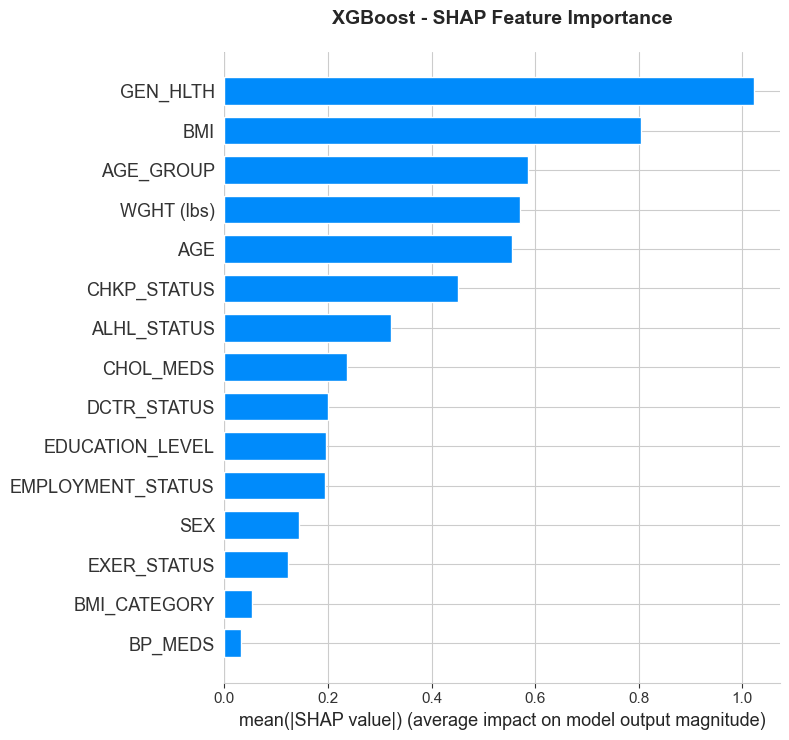

In [28]:
# SHAP Summary Plot for XGBoost
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_xgb, X_test_sample, plot_type="bar", show=False)
plt.title('XGBoost - SHAP Feature Importance', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

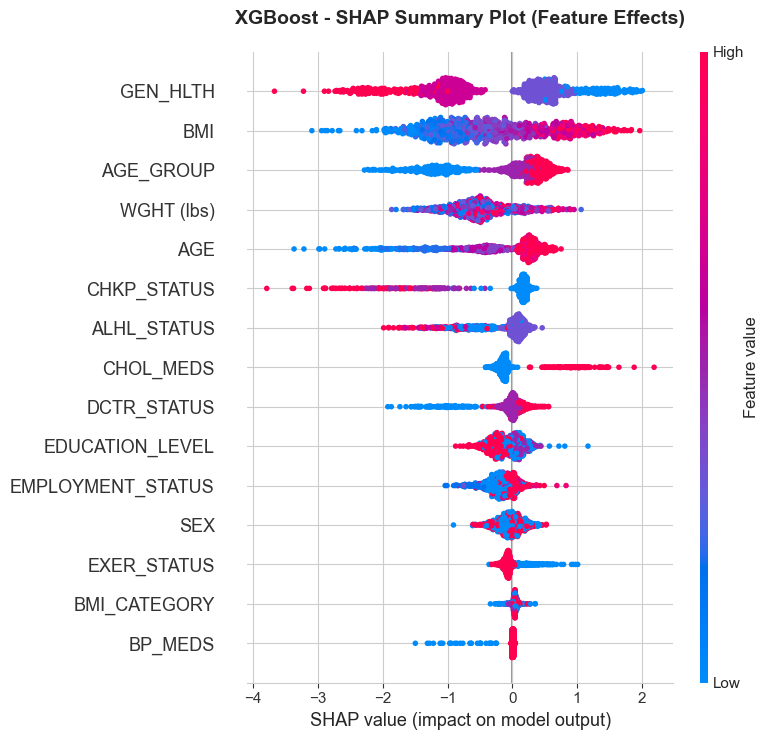

In [29]:
# SHAP Beeswarm Plot for XGBoost
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_xgb, X_test_sample, show=False)
plt.title('XGBoost - SHAP Summary Plot (Feature Effects)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


Explaining XGBoost prediction for test instance 0:
Actual class: 0
Predicted class: 0
Predicted probability: 0.0009


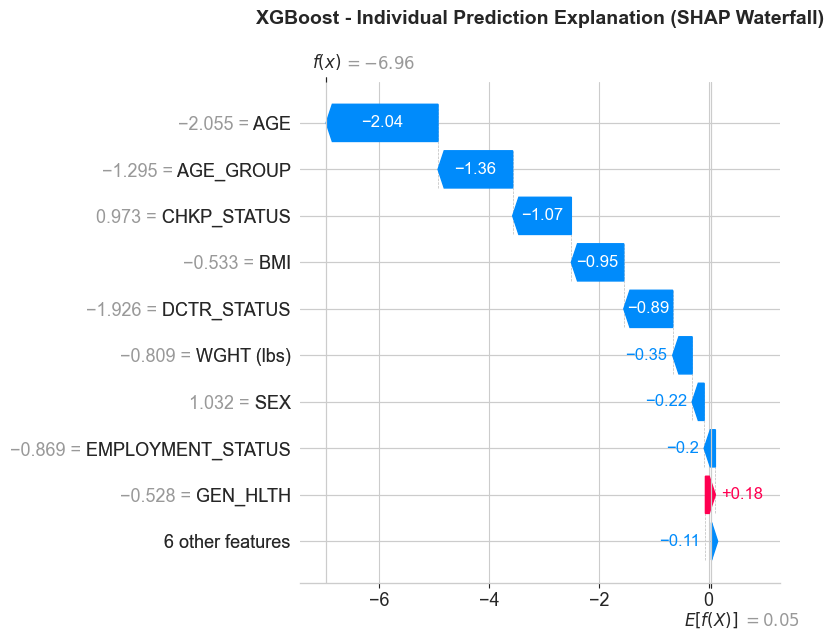

In [30]:
# Individual prediction explanation for XGBoost
print(f"\nExplaining XGBoost prediction for test instance {instance_idx}:")
print(f"Actual class: {y_test.iloc[X_test_sample.index[instance_idx]]}")
print(f"Predicted class: {xgb.predict(X_test_sample.iloc[[instance_idx]])[0]}")
print(f"Predicted probability: {xgb.predict_proba(X_test_sample.iloc[[instance_idx]])[0][1]:.4f}")

shap_explanation_xgb = shap.Explanation(
    values=shap_values_xgb[instance_idx],
    base_values=explainer_xgb.expected_value,
    data=X_test_sample.iloc[instance_idx],
    feature_names=X_test_sample.columns.tolist()
)

plt.figure(figsize=(12, 6))
shap.waterfall_plot(shap_explanation_xgb, show=False)
plt.title('XGBoost - Individual Prediction Explanation (SHAP Waterfall)', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 11. Model Explainability with LIME (RO3 Requirement)

**LIME (Local Interpretable Model-agnostic Explanations)** provides:
- Local explanations for individual predictions
- Works with any black-box model
- Complements SHAP analysis

### 11.1 LIME for XGBoost

In [31]:
print("="*80)
print("LIME ANALYSIS FOR XGBOOST")
print("="*80)

# Create LIME explainer
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_resampled),
    feature_names=X_train_resampled.columns.tolist(),
    class_names=['No Diabetes', 'Has Diabetes'],
    mode='classification',
    random_state=42
)

print("LIME explainer created successfully")

LIME ANALYSIS FOR XGBOOST
LIME explainer created successfully



LIME Explanation for Test Instance 0
Actual Class: 0 (No Diabetes)
Predicted Class: 0 (No Diabetes)
Prediction Probability: No Diabetes=0.9991, Has Diabetes=0.0009

Top features contributing to this prediction:
  CHKP_STATUS > -0.40: -0.0016
  AGE_GROUP <= -1.29: -0.0015
  WGHT (lbs) <= -0.60: -0.0015
  AGE <= -0.84: -0.0013
  GEN_HLTH <= -0.53: -0.0013
  -0.59 < BMI <= -0.00: -0.0013
  BMI_CATEGORY <= -1.18: -0.0011
  -1.15 < EDUCATION_LEVEL <= -0.11: -0.0010
  ALHL_STATUS <= -0.04: +0.0008
  DCTR_STATUS <= -0.33: +0.0007


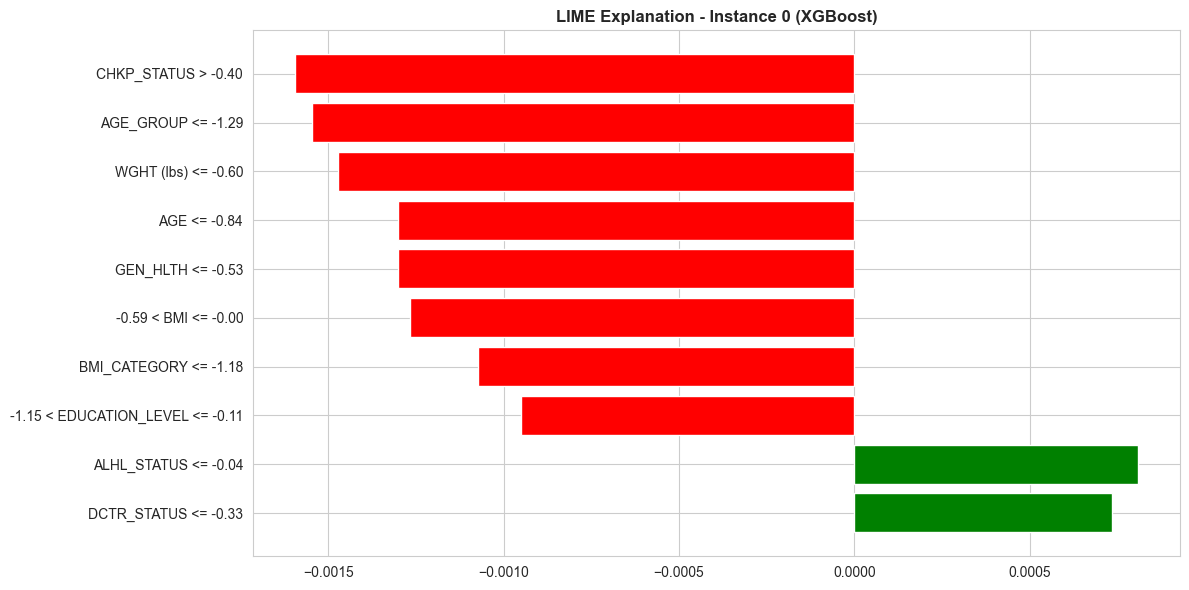


LIME Explanation for Test Instance 10
Actual Class: 0 (No Diabetes)
Predicted Class: 0 (No Diabetes)
Prediction Probability: No Diabetes=0.9351, Has Diabetes=0.0649

Top features contributing to this prediction:
  ALHL_STATUS <= -0.04: +0.0014
  -0.60 < WGHT (lbs) <= -0.02: -0.0013
  -0.11 < EDUCATION_LEVEL <= 0.93: -0.0009
  0.37 < AGE <= 0.98: -0.0008
  0.02 < BMI_CATEGORY <= 1.23: -0.0007
  CHKP_STATUS <= -0.40: -0.0007
  -0.00 < BMI <= 0.73: -0.0007
  DCTR_STATUS <= -0.33: +0.0006
  -0.09 < AGE_GROUP <= 1.12: -0.0005
  -0.51 < EMPLOYMENT_STATUS <= 1.30: -0.0005


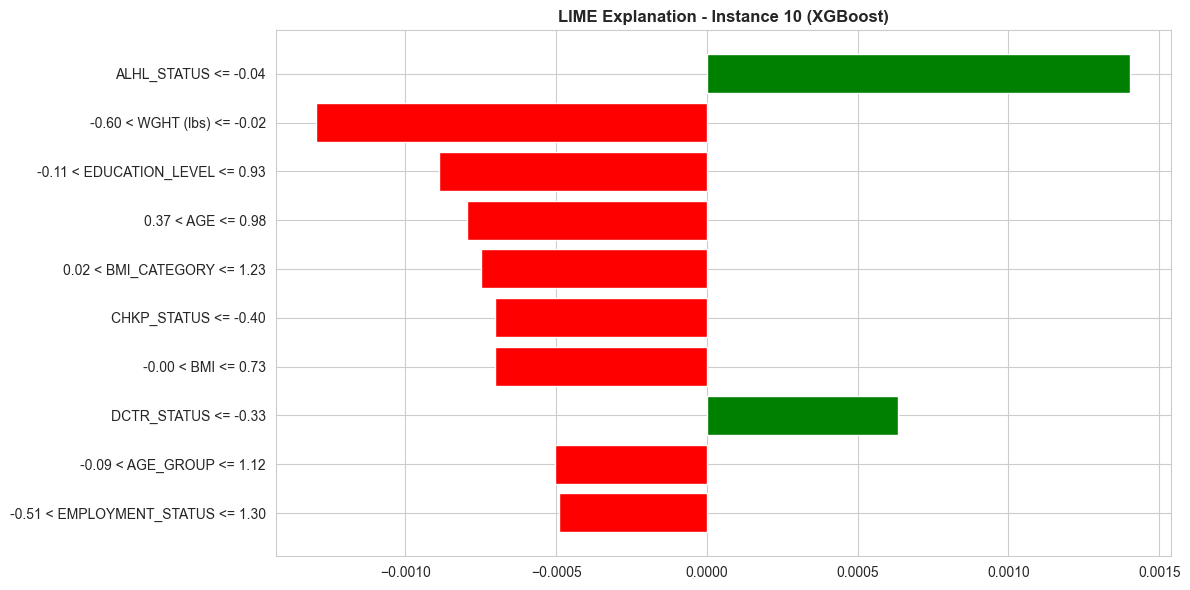


LIME Explanation for Test Instance 50
Actual Class: 0 (No Diabetes)
Predicted Class: 0 (No Diabetes)
Prediction Probability: No Diabetes=0.9893, Has Diabetes=0.0107

Top features contributing to this prediction:
  AGE <= -0.84: -0.0014
  WGHT (lbs) > 0.75: -0.0010
  -0.59 < BMI <= -0.00: -0.0010
  AGE_GROUP <= -1.29: -0.0010
  -1.18 < BMI_CATEGORY <= 0.02: -0.0009
  ALHL_STATUS <= -0.04: +0.0007
  EDUCATION_LEVEL <= -1.15: -0.0007
  -0.97 < SEX <= 1.03: -0.0007
  -0.53 < GEN_HLTH <= 0.51: -0.0005
  CHOL_MEDS <= -0.36: -0.0005


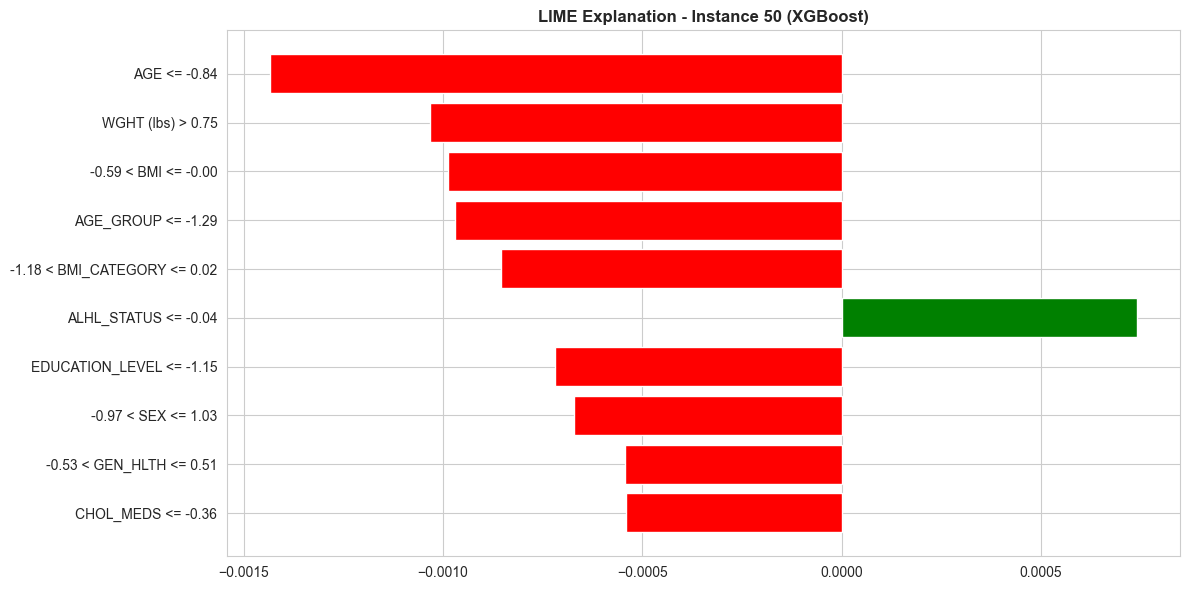

In [33]:
# Explain individual predictions with LIME
# Select a few instances to explain
instances_to_explain = [0, 10, 50]  # You can change these indices

for idx in instances_to_explain:
    instance = X_test_sample.iloc[idx].values
    # Use .loc instead of .iloc to get the actual value by index label
    actual = y_test.loc[X_test_sample.index[idx]]
    predicted = xgb.predict(X_test_sample.iloc[[idx]])[0]
    probability = xgb.predict_proba(X_test_sample.iloc[[idx]])[0]
    
    print(f"\n{'='*80}")
    print(f"LIME Explanation for Test Instance {idx}")
    print(f"{'='*80}")
    print(f"Actual Class: {actual} ({'Has Diabetes' if actual == 1 else 'No Diabetes'})")
    print(f"Predicted Class: {predicted} ({'Has Diabetes' if predicted == 1 else 'No Diabetes'})")
    print(f"Prediction Probability: No Diabetes={probability[0]:.4f}, Has Diabetes={probability[1]:.4f}")
    
    # Generate explanation
    explanation = lime_explainer.explain_instance(
        data_row=instance,
        predict_fn=xgb.predict_proba,
        num_features=10
    )
    
    # Show explanation
    print("\nTop features contributing to this prediction:")
    for feature, weight in explanation.as_list():
        print(f"  {feature}: {weight:+.4f}")
    
    # Plot explanation
    fig = explanation.as_pyplot_figure()
    plt.title(f'LIME Explanation - Instance {idx} (XGBoost)', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 12. Extracting Explanation Logic for App Development (RO3)

This section provides templates and logic for implementing explanations in the final diabetes risk app.

In [34]:
# Extract top features from SHAP analysis
mean_abs_shap = np.abs(shap_values_xgb).mean(axis=0)
feature_importance_df = pd.DataFrame({
    'Feature': X_test_sample.columns,
    'SHAP_Importance': mean_abs_shap
}).sort_values('SHAP_Importance', ascending=False)

print("Top 10 Risk Factors for Diabetes (by SHAP importance):")
print("="*80)
display(feature_importance_df.head(10))

# Save for app development
feature_importance_df.to_csv('diabetes_risk_factors_ranking.csv', index=False)
print("\nRisk factors ranking saved to 'diabetes_risk_factors_ranking.csv'")

Top 10 Risk Factors for Diabetes (by SHAP importance):


,Feature,SHAP_Importance
2,GEN_HLTH,1.021768
5,BMI,0.804168
0,AGE_GROUP,0.586680
3,WGHT (lbs),0.569866
1,AGE,0.554436
7,CHKP_STATUS,0.451359
14,ALHL_STATUS,0.322429
12,CHOL_MEDS,0.236837
10,DCTR_STATUS,0.200107
13,EDUCATION_LEVEL,0.196201



Risk factors ranking saved to 'diabetes_risk_factors_ranking.csv'


In [35]:
# Create explanation templates based on SHAP analysis
explanation_templates = {
    'GEN_HLTH': "Your general health status is a {direction} contributor to diabetes risk.",
    'HIGH_BP': "{'Having' if value > 0.5 else 'Not having'} high blood pressure {direction} affects your diabetes risk.",
    'BMI': "Your BMI level is {direction} influencing your diabetes risk.",
    'AGE': "Your age is a {direction} factor in diabetes risk assessment.",
    'HIGH_CHOL': "{'Having' if value > 0.5 else 'Not having'} high cholesterol {direction} impacts your diabetes risk.",
    'INCOME_LEVEL': "Your income level shows a {direction} association with diabetes risk.",
    'PHYS_HLTH_DAYS': "The number of days you experienced poor physical health is {direction} related to diabetes risk.",
    'EDUCATION_LEVEL': "Your education level shows a {direction} association with diabetes risk.",
    'EXER_STATUS': "Your exercise habits are {direction} influencing your diabetes risk.",
    'HAD_HEARTDISEASE': "{'Having' if value > 0.5 else 'Not having'} heart disease history {direction} affects diabetes risk."
}

print("\nExplanation Templates for App Development:")
print("="*80)
for feature, template in explanation_templates.items():
    print(f"\n{feature}:")
    print(f"  Template: {template}")
    print(f"  Note: Replace {{direction}} with 'positively'/'negatively' based on SHAP value")


Explanation Templates for App Development:

GEN_HLTH:
  Template: Your general health status is a {direction} contributor to diabetes risk.
  Note: Replace {direction} with 'positively'/'negatively' based on SHAP value

HIGH_BP:
  Template: {'Having' if value > 0.5 else 'Not having'} high blood pressure {direction} affects your diabetes risk.
  Note: Replace {direction} with 'positively'/'negatively' based on SHAP value

BMI:
  Template: Your BMI level is {direction} influencing your diabetes risk.
  Note: Replace {direction} with 'positively'/'negatively' based on SHAP value

AGE:
  Template: Your age is a {direction} factor in diabetes risk assessment.
  Note: Replace {direction} with 'positively'/'negatively' based on SHAP value

HIGH_CHOL:
  Template: {'Having' if value > 0.5 else 'Not having'} high cholesterol {direction} impacts your diabetes risk.
  Note: Replace {direction} with 'positively'/'negatively' based on SHAP value

INCOME_LEVEL:
  Template: Your income level shows a 

## 13. Save Best Model

In [36]:
import joblib

# Determine best model based on ROC-AUC
best_model_name = results.loc[results['ROC-AUC'].idxmax(), 'Model']
print(f"Best performing model: {best_model_name}")

# Save the best model
if best_model_name == 'Logistic Regression':
    best_model = lr
elif best_model_name == 'Random Forest':
    best_model = rf
elif best_model_name == 'XGBoost':
    best_model = xgb
else:  # LightGBM
    best_model = lgbm

# Save model and scaler
joblib.dump(best_model, 'best_diabetes_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')

print(f"\nBest model saved as 'best_diabetes_model.pkl'")
print("Feature scaler saved as 'feature_scaler.pkl'")

# Save feature names
pd.DataFrame({'features': X.columns}).to_csv('model_features.csv', index=False)
print("Feature names saved as 'model_features.csv'")

Best performing model: LightGBM

Best model saved as 'best_diabetes_model.pkl'
Feature scaler saved as 'feature_scaler.pkl'
Feature names saved as 'model_features.csv'


## 14. Final Summary & Recommendations

In [37]:
print("\n" + "="*80)
print("FINAL MODEL DEVELOPMENT SUMMARY (RO3)")
print("="*80)
print(f"\nDataset: Combined BRFSS 2023 & 2024")
print(f"Total samples: {len(data):,}")
print(f"Training samples (after SMOTEENN): {len(X_train_resampled):,}")
print(f"Test samples: {len(X_test):,}")
print(f"Number of features: {X.shape[1]}")
print(f"\nModels Trained:")
print("  1. Logistic Regression (LR)")
print("  2. Random Forest (RF)")
print("  3. XGBoost (Extreme Gradient Boosting)")
print("  4. LightGBM (Light Gradient Boosting Machine)")
print(f"\nBest Model: {best_model_name}")
print(f"Best ROC-AUC Score: {results['ROC-AUC'].max():.4f}")
print(f"\nExplainability Methods Applied:")
print("  ✓ SHAP (SHapley Additive exPlanations)")
print("    - Global feature importance")
print("    - Individual prediction explanations")
print("    - Feature effect visualization")
print("  ✓ LIME (Local Interpretable Model-agnostic Explanations)")
print("    - Local prediction explanations")
print("    - Feature contribution analysis")
print(f"\nDeliverables for App Development:")
print("  ✓ Trained model: best_diabetes_model.pkl")
print("  ✓ Feature scaler: feature_scaler.pkl")
print("  ✓ Feature list: model_features.csv")
print("  ✓ Risk factors ranking: diabetes_risk_factors_ranking.csv")
print("  ✓ Explanation templates: Documented above")
print("\nNext Steps for RO3:")
print("  1. Integrate model into Streamlit/mobile app")
print("  2. Implement SHAP-based explanations for user predictions")
print("  3. Design UI showing top risk factors")
print("  4. Conduct usability testing with older adults")
print("  5. Evaluate using System Usability Scale (SUS)")
print("="*80)


FINAL MODEL DEVELOPMENT SUMMARY (RO3)

Dataset: Combined BRFSS 2023 & 2024
Total samples: 727,123
Training samples (after SMOTEENN): 566,352
Test samples: 218,137
Number of features: 15

Models Trained:
  1. Logistic Regression (LR)
  2. Random Forest (RF)
  3. XGBoost (Extreme Gradient Boosting)
  4. LightGBM (Light Gradient Boosting Machine)

Best Model: LightGBM
Best ROC-AUC Score: 0.7775

Explainability Methods Applied:
  ✓ SHAP (SHapley Additive exPlanations)
    - Global feature importance
    - Individual prediction explanations
    - Feature effect visualization
  ✓ LIME (Local Interpretable Model-agnostic Explanations)
    - Local prediction explanations
    - Feature contribution analysis

Deliverables for App Development:
  ✓ Trained model: best_diabetes_model.pkl
  ✓ Feature scaler: feature_scaler.pkl
  ✓ Feature list: model_features.csv
  ✓ Risk factors ranking: diabetes_risk_factors_ranking.csv
  ✓ Explanation templates: Documented above

Next Steps for RO3:
  1. Integra

In [38]:
# Save final comparison results
results.to_csv('model_comparison_results.csv', index=False)
print("\nModel comparison results saved to 'model_comparison_results.csv'")

print("\n✓ All analyses complete!")
print("✓ Models trained and evaluated")
print("✓ SHAP and LIME explainability implemented")
print("✓ Ready for prototype development (RO3)")


Model comparison results saved to 'model_comparison_results.csv'

✓ All analyses complete!
✓ Models trained and evaluated
✓ SHAP and LIME explainability implemented
✓ Ready for prototype development (RO3)
